In [3]:
# import and config
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from zipfile import ZipFile
from pathlib import Path
from os import getcwd, listdir, path
import os 
import scipy.io
import warnings
from typing import Dict, Generic
from sklearn import preprocessing
from typing import TypeVar
import PyQt5


warnings.filterwarnings('ignore')
%matplotlib qt

%cd /home/matej/2-fer/uuzop/projekt

UNZIP_DATA = False

PATH_CWD = Path(getcwd()) 

PATH_DATA = Path(PATH_CWD, "data")
PATH_DATA_MAT = Path(PATH_DATA, "mat")
PATH_DATA_CNT = Path(PATH_DATA, "cnt")

PATH_ZIP_CNT = Path(PATH_DATA, "5202739.zip")
PATH_ZIP_MAT = Path(PATH_DATA, "5202751.zip")



/home/matej/2-fer/uuzop/projekt


In [4]:
# Abstractions
T = TypeVar('T') #Any

In [5]:
# CNT - unzip and restructure data
if  UNZIP_DATA:
    with ZipFile(PATH_ZIP_CNT, 'r') as zip_ref:
        zip_ref.extractall(PATH_DATA_CNT)
    
    zips = [file for file in PATH_DATA_CNT.iterdir() if str(file).endswith(".zip")]
    
    for zip_item in zips:
        
        if not str(zip_item).endswith(".zip"):
            continue
        
        zip_ref = ZipFile(zip_item) # create zipfile object
        
        for cnt_file in zip_ref.namelist()[1:]: # ignore "9/" directory
        
            prefix_number = zip_item.stem # 9
            state_name = Path(cnt_file).stem.lower().split(' ')[0] # "Normal State" -> "normal"
            filename = Path(prefix_number + '_' + state_name + ".cnt")
            
            with open(Path(PATH_DATA_CNT, filename), "wb") as new_file:
                new_file.write(zip_ref.read(cnt_file))
                
    # Delete zips as they were temporary
    for zip_item in zips:
    	os.remove(zip_item)

In [6]:
# MAT - unzip data
if  UNZIP_DATA:
    with ZipFile(PATH_ZIP_MAT, 'r') as zip_ref:
        zip_ref.extractall(PATH_DATA_MAT)

In [7]:

mat = scipy.io.loadmat(Path(PATH_DATA_MAT, '2.mat'))
keys = [key for key in mat.keys() if not key.startswith('__')]

[print(key, "with shape",mat[key].shape) for key in keys]

is_normal_state_mask = pd.Series(mat["Class_label"].squeeze() == 0)
keys_entropy = ["FE", "SE", "AE", "PE"]
print(is_normal_state_mask)

entropies: Dict[str,pd.DataFrame]={}
for key in keys_entropy:
    entropies[key] = pd.DataFrame(mat[key])
    print(key, "\n",entropies[key].describe()) 
      


OSError: Reader needs file name or open file-like object

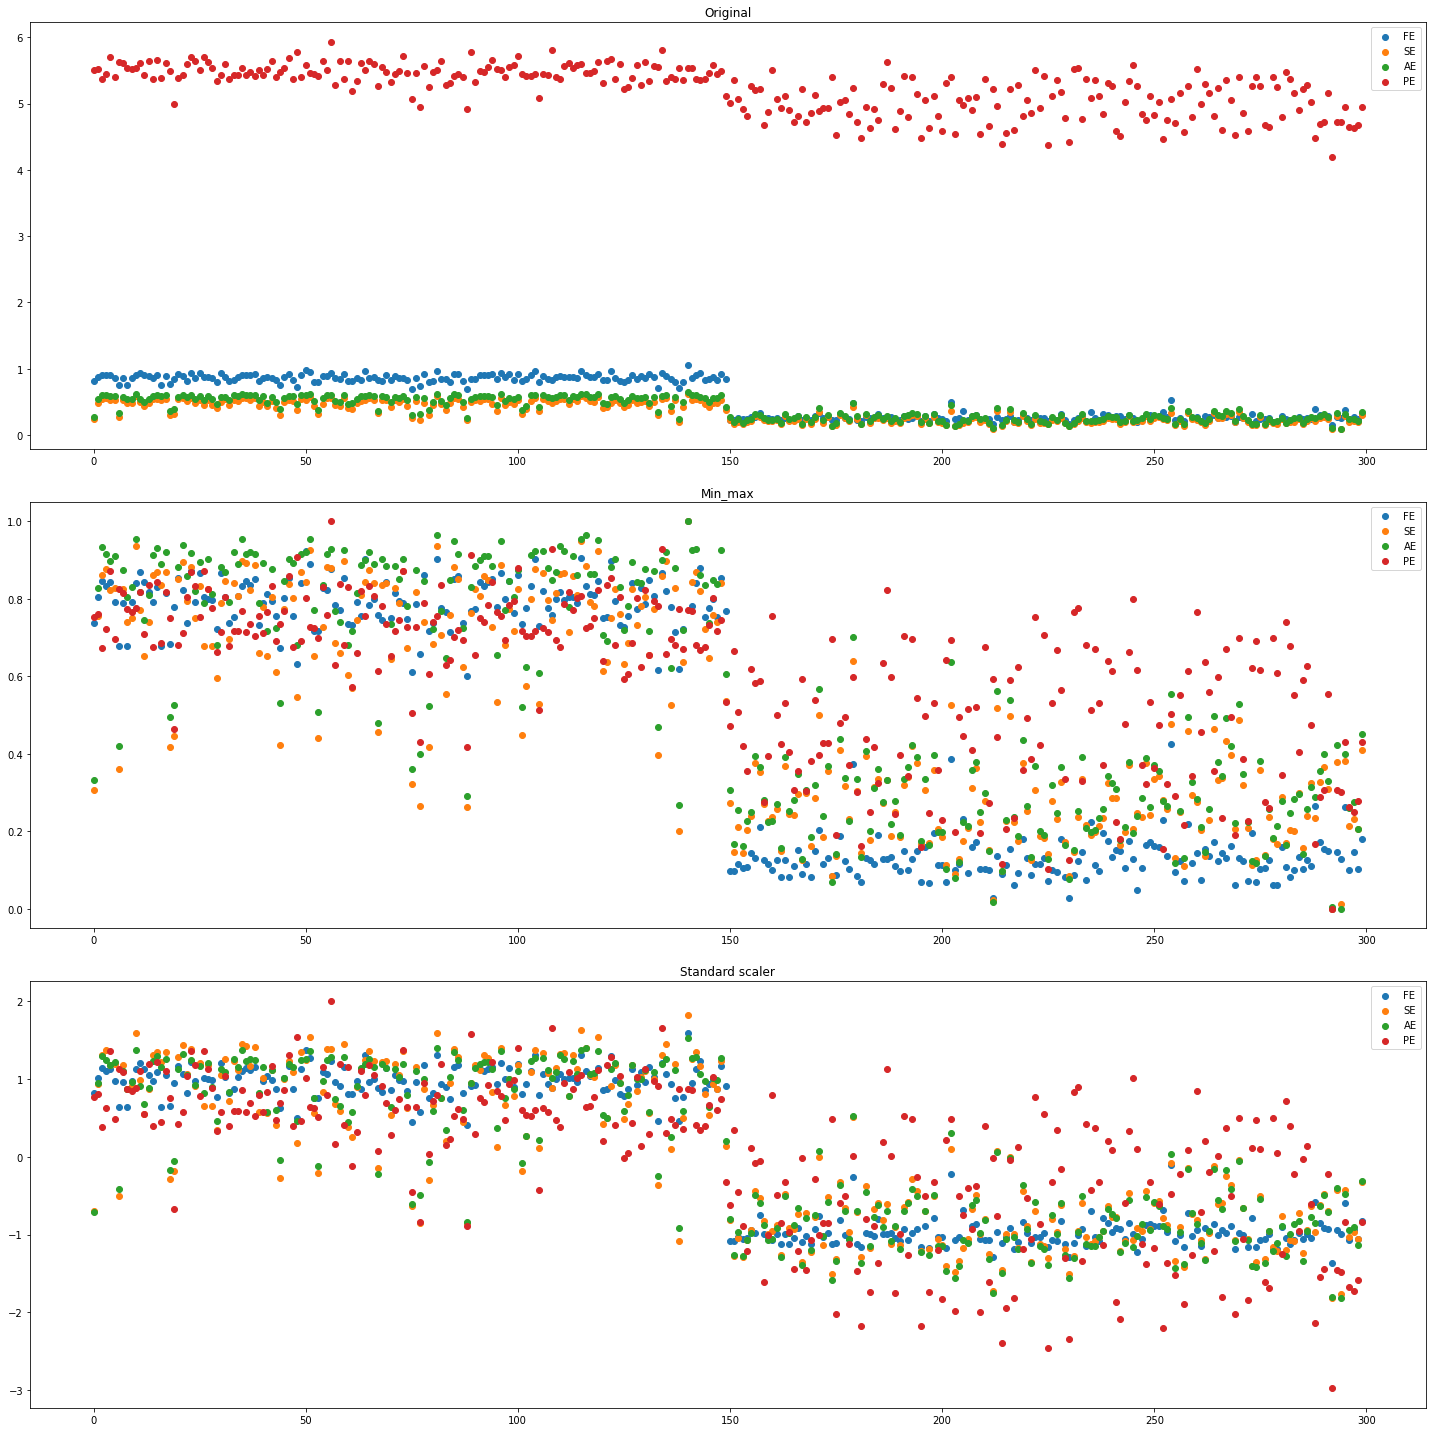

In [ ]:
        
def dict_apply_procedture(old_dict: Dict[str, T], procedure) -> Dict[str, T]:
    return {k: procedure(v) for k, v in old_dict.items()}
    
def min_max_dataframe(df: pd.DataFrame):
    return pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(df))

def standard_scale_dataframe(df: pd.DataFrame):
    return pd.DataFrame(preprocessing.StandardScaler().fit_transform(df))

fig = plt.figure(figsize=(20,20), tight_layout={"h_pad": 2})

ax = fig.add_subplot(3,1, 1)
for name, entropy in entropies.items():
    ax.set_title("Original")
    ax.scatter(entropy.index.tolist(), entropy.loc[:,1],  label=name)
    ax.legend()

entropies_scaled = dict_apply_procedture(entropies, min_max_dataframe)
ax = fig.add_subplot(3,1, 2)
for name, entropy in entropies_scaled.items():
    ax.set_title("Min_max")
    ax.scatter(entropy.index.tolist(), entropy.loc[:,1],  label=name)
    ax.legend()
    
entropies_scaled_2 = dict_apply_procedture(entropies, standard_scale_dataframe)
ax = fig.add_subplot(3,1, 3)
for name, entropy in entropies_scaled_2.items():
    ax.set_title("Standard scaler")
    ax.scatter(entropy.index.tolist(), entropy.loc[:,1],  label=name)
    ax.legend()
    



In [ ]:
# Null and NaN are the same in Pandas :)

def isnull_any(df):
    return df.isnull().any()

def isnull_values_sum(df):
    return df.isnull().values.sum() > 0

def isnull_sum(df):
    return df.isnull().sum() > 0

def isnull_values_any(df):
    return df.isnull().values.any()

def rows_with_null(df):
    return df[df.isnull().any(axis=1)]

for name, entropy in entropies_scaled.items():
    if (isnull_values_any(entropy)):
        print("Entropy", name, "has null values")
    if (isnull_values_any(entropy)):
        print("Entropy", name, "has null values")

In [21]:
# mne signal processing

# In addition each BCIT dataset includes 4 additional EOG channels placed vertically above the right eye (veou), vertically below the right eye (veol), horizontally on the outside of the right eye (heor), and horizontally on the outside of the left eye (heol)


# sample_data_folder = mne.datasets.sample.data_path()
# sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
#                                     'sample_audvis_filt-0-40_raw.fif')

# raw.crop(...).pick_channels(...).filter(...).plot()



raw = mne.io.read_raw_cnt(str(Path(PATH_DATA_CNT, "1_normal.cnt")), eog=['HEOL', "HEOR", "VEOU", "VEOL"])
print(raw.ch_names)
print(raw.info)
# raw.info['bads']=['FC4', 'F7']
# print(len(raw) / raw.info['sfreq'] / 2) = half tmin
if not eeg:
	eeg = raw.load_data().notch_filter(50).filter(l_freq=0.15, h_freq=40).crop(tmin=300)
print(eeg.info)


epochs = mne.make_fixed_length_epochs(eeg, duration=1, preload=False)
alpha_data = epochs.to_data_frame()
alpha_data.tail()

# ica.fit(raw)
# ica.exclude = [1, 2]  # details on how we picked these are omitted here
# ica.plot_properties(raw, picks=ica.exclude)
# raw.plot()
# raw.plot_psd(fmin=0,tmin=0, tmax=1)
# raw.plot(duration=5, )


['HEOL', 'HEOR', 'FP1', 'FP2', 'VEOU', 'VEOL', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FT7', 'FC3', 'FCZ', 'FC4', 'FT8', 'T3', 'C3', 'CZ', 'C4', 'T4', 'TP7', 'CP3', 'CPZ', 'CP4', 'TP8', 'A1', 'T5', 'P3', 'PZ', 'P4', 'T6', 'A2', 'O1', 'OZ', 'O2', 'FT9', 'FT10', 'PO1', 'PO2']
<Info | 8 non-empty values
 bads: []
 ch_names: HEOL, HEOR, FP1, FP2, VEOU, VEOL, F7, F3, FZ, F4, F8, FT7, FC3, ...
 chs: 4 EOG, 36 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 40
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 5 items (dict)
>
<Info | 8 non-empty values
 bads: []
 ch_names: HEOL, HEOR, FP1, FP2, VEOU, VEOL, F7, F3, FZ, F4, F8, FT7, FC3, ...
 chs: 4 EOG, 36 EEG
 custom_ref_applied: False
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 40
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 5 items (dict)
>
Not setting metadata
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Loading data fo

,time,condition,epoch,HEOL,HEOR,FP1,FP2,VEOU,VEOL,F7,...,P4,T6,A2,O1,OZ,O2,FT9,FT10,PO1,PO2
299995,995,1,299,191.676000,-0.376450,-448.879830,0.138798,-950.725511,-0.313709,1307.045366,...,506.103061,-4.624457e-17,-310.217824,-0.138798,-73.707591,-0.092532,-307.602319,-0.115665,-469.016051,-0.092532
299996,996,1,299,-1369.212883,-0.313709,-448.592813,0.138835,304.109190,-0.250967,1307.260873,...,506.588101,-4.655476e-17,-309.720534,-0.138835,-73.429834,-0.092556,-307.532636,-0.115696,-468.991187,-0.092556
299997,997,1,299,194.373895,-0.376450,-448.339294,0.138909,-951.980345,-0.313709,1308.015552,...,507.304090,-5.115595e-17,-309.334544,-0.138909,-73.149225,-0.092606,-307.561322,-0.115757,-469.112665,-0.092606
299998,998,1,299,-1368.710949,-0.313709,-447.893938,0.138945,304.360157,-0.250967,1308.584797,...,507.947310,-5.810944e-17,-308.905057,-0.138945,-72.831214,-0.092630,-307.520617,-0.115788,-469.123578,-0.092630
299999,999,1,299,193.558253,-0.376450,-447.517598,0.139019,-952.356796,-0.313709,1309.656521,...,508.769613,-6.661389e-17,-308.624413,-0.139019,-72.536498,-0.092679,-307.595086,-0.115849,-469.294157,-0.092679
